In [27]:
from robot import robot
from measurer import global_measurer

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from IPython import display
import time
from matplotlib.lines import Line2D
    
%matplotlib inline

In [2]:
class Kalman(object):
    def __init__(self, measure_noise=1, control_noise=(0.1, 0.1)):
        self.position_mu = np.zeros(2)
        self.position_sigma = np.eye(2) * 100
        
        self.last_measure_time = 0
        
        self.measure_noise = measure_noise
        self.control_noise = control_noise
        
    def _A(self, t):
        return np.eye(2)
    
    def _B(self, t):
        return np.eye(2) * (t - self.last_measure_time)
    
    def _R(self, t):
        R = np.eye(2)
        R[0, 0] *= self.control_noise[0]**2
        R[1, 1] *= self.control_noise[1]**2
        
        return R
    
    def _C(self, t):
        return np.eye(2)
    
    def _Q(self, t):
        return np.eye(2) * self.measure_noise**2
        
    def predict(self, robot_velocity, t):
        predicted_mu = self._A(t).dot(self.position_mu) + self._B(t).dot(robot_velocity)
        predicted_sigma = self._A(t).dot(self.position_sigma).dot(self._A(t).T) + self._R(t)
        
        self.position_mu = predicted_mu
        self.position_sigma = predicted_sigma
    
    def update(self, position, t):
        K_t = self.position_sigma.dot(self._C(t).T).dot(
            np.linalg.inv(
                self._C(t).dot(self.position_sigma).dot(self._C(t)) + self._Q(t)
            ))
        
        self.position_mu = self.position_mu + K_t.dot(position - self._C(t).dot(self.position_mu))
        self.position_sigma = (np.eye(2) - K_t.dot(self._C(t))).dot(self.position_sigma)
        self.last_measure_time = t

In [9]:
def draw_position(position, covariance, color='black', ax=None):
    """
    Confidence ellipse of 3 sigma
    """
    lambda_, v = np.linalg.eig(covariance)
    lambda_ = np.sqrt(lambda_)
    
    if ax is None:
        ax = plt.subplot(111, aspect='equal')

    ell = Ellipse(xy=(position),
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
    
    ell.set_facecolor('none')
    ell.set_edgecolor(color)
    ax.add_artist(ell)
    
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    
    
    ax.scatter(position[0], position[1], c=color)
    return ax

In [29]:
r = robot.Robot(pos=np.array((-7, 0)), vel=np.array((0.5, 0.1)), odometer_noise_x=0.5, odometer_noise_y=0.1)
m = global_measurer.GlobalMeasurer(noise=0.3)
k = Kalman(control_noise=(0.5, 0.1), measure_noise=0.3)

dt = 0.5
t = 0

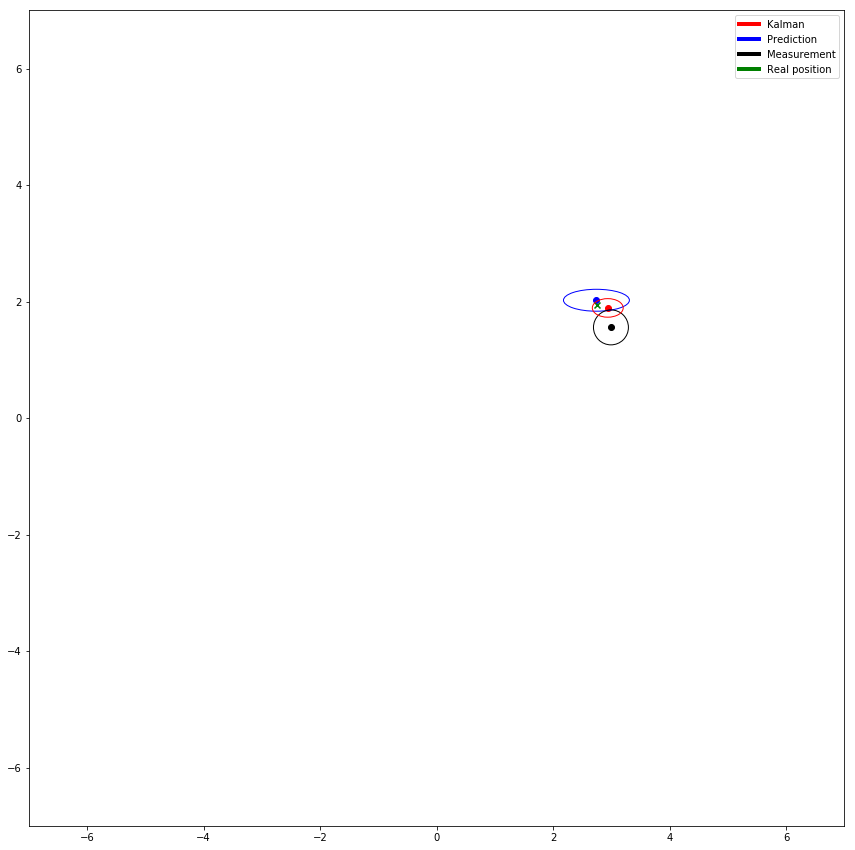

In [30]:

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111, aspect='equal')

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='green', lw=4)]


real_track = []
measured_track = []
kalman_track = []

for i in range(40):
    ax.clear()
    
    ax.legend(custom_lines, ['Kalman', 'Prediction', 'Measurement', 'Real position'])
    
    k.predict(r.velocity(), t)
    draw_position(k.position_mu, k.position_sigma, ax=ax, color='blue')
    pos = m.measure(r)
    draw_position(pos, np.eye(2) * k.measure_noise**2, ax=ax)
    
    k.update(pos, t)
    draw_position(k.position_mu, k.position_sigma, ax=ax, color='red')
    ax.scatter(r.state_[0], r.state_[1], marker='x', color='green')
    t += dt
    r.move(dt)
    
    real_track.append((r.state_[0], r.state_[1]))
    measured_track.append(pos)
    kalman_track.append(k.position_mu)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

display.clear_output(wait=True)


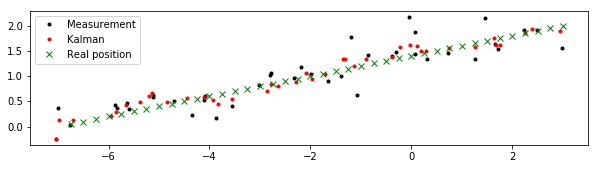

In [37]:
measured_track = np.array(measured_track)
real_track = np.array(real_track)
kalman_track = np.array(kalman_track)

plt.figure(figsize=(10, 10))
plt.subplot(111, aspect='equal')
plt.plot(measured_track[:, 0], measured_track[:, 1], '.', c="black", label='Measurement')
plt.plot(kalman_track[:, 0], kalman_track[:, 1], 'r.', label="Kalman")
plt.plot(real_track[:, 0], real_track[:, 1], 'gx', label="Real position")
plt.legend()